<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은
<font color = blue>정답 값이 들어올 때 훈련없이 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [18]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [19]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [20]:
import configparser
import os
config = configparser.ConfigParser()
config['1step-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('1step-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'1step-NLinear')

['/hdd_1/sjlee/Paper_Project/1step-NLinear']

In [21]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['1step-NLinear']['seq_len'])
        self.pred_len = int(configs['1step-NLinear']['pred_len'])
        self.channels = int(configs['1step-NLinear']['enc_in'])
        self.individual = configs['1step-NLinear']['individual']
        self.device = torch.device('cuda:0')
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        # https://bo-10000.tistory.com/181
        x = (x-seq_last)
        seq_last = seq_last.to(self.device)
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1).to(self.device)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [22]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [23]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [24]:
import torch.optim as optim

In [25]:
device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남
device = torch.device("cuda:0")

Adjusting learning rate of group 0 to 1.0000e-05.


In [26]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [27]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        out = model(seq.permute(0,2,1))
        
        loss = criterion(out,tg)
       
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.5000e-06.
smape 19.102068853657148 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 15.389827316877438 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 13.91730690647287 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 13.11594583965533 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 12.665352928969595 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 12.35911571186537 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 12.153871846739312 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 11.990944199394761 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 11.845558847774539 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 11.710218227310488 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 11.577402556761664 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 11.460784203563518 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 11.357229094059146 %
Ad

In [28]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    if idx == 0:
        new_train = torch.FloatTensor(
        [X.iloc[-sequence_length:].values]).view(1,sequence_length,1).to(device)
                
    elif idx < sequence_length:
        new_train = torch.FloatTensor(
            [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,sequence_length,1).to(device)
    elif idx >= sequence_length:
        new_train = torch.FloatTensor(
            [target.iloc[idx-sequence_length:idx].values]
            ).view(1,sequence_length,1).to(device)

    with torch.no_grad():
        model.eval()
        out = model(new_train).to(device) # 예측완료
        end = time.time()
        pred_list.append(out.cpu().view(1).item())
        time_list.append(end-start)

<font color = blue> with torch.no_grad()와 model.eval()의 차이</font>
with torch.no_grad() pytorch는 autograd engine을 꺼버리고 이말은 gradient를 계산하지 않는 다는 의미이다 그렇다면 loss.backward()를 하지 않으면 gradient를 계산하든지 말든지 상관이 없다는 말인데 맞는 말이다 이는 단지 속도를 올리기 위해서 감싸는 것이다
그렇다면 model.eval()은 어디에 쓰는 것인가 model.eval()의 목표 몇몇 모델이 training과 inference를 다르게 동작하는 경우가 있기때문에 inference mode로 바꿔주는데 있다

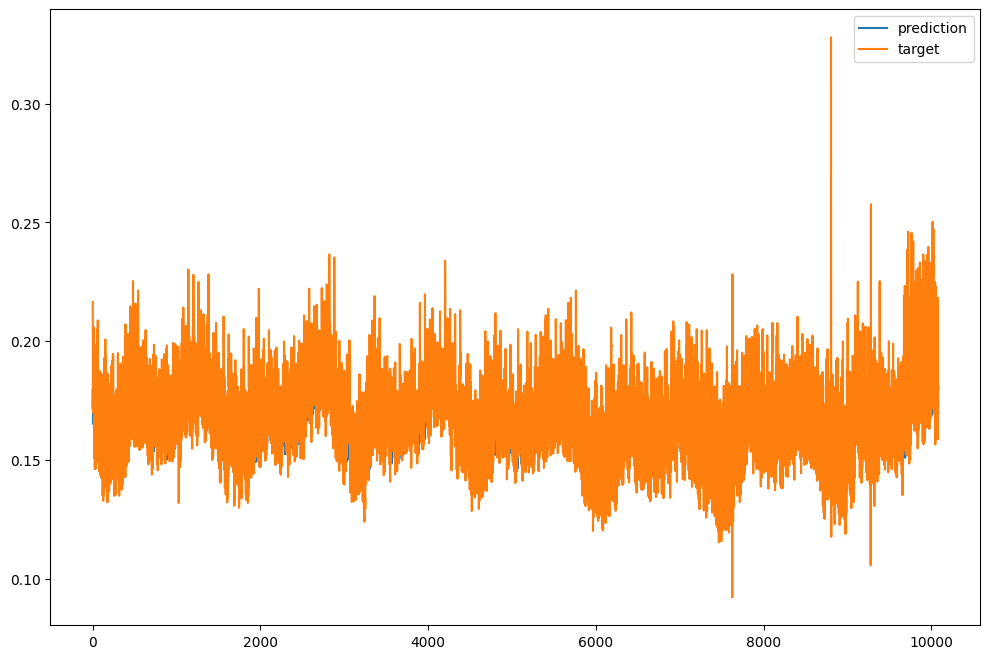

In [29]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [30]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 6.579539775848389 %


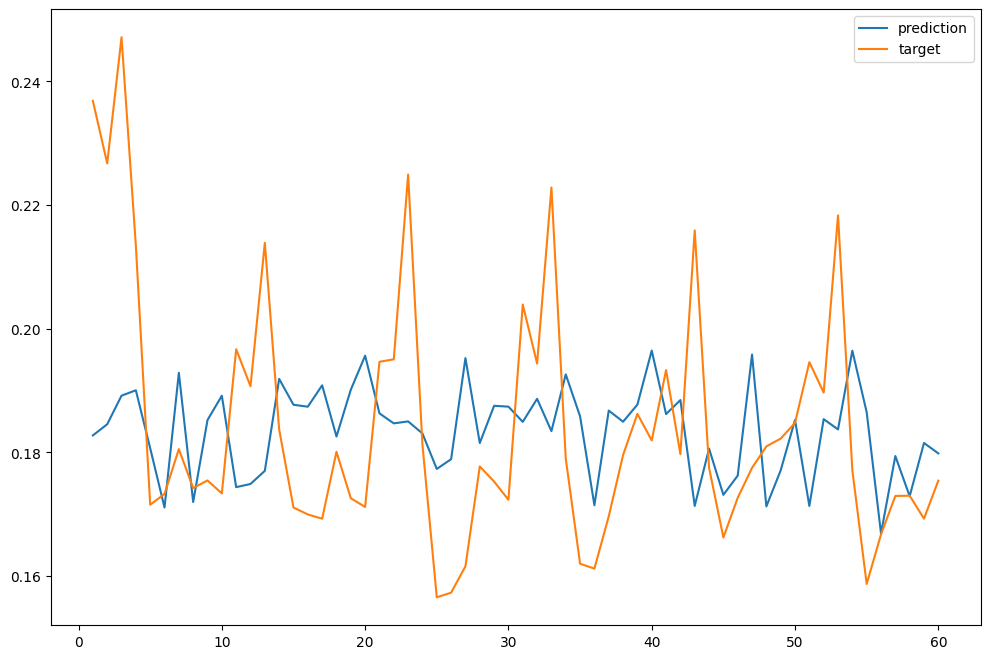

In [31]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()